<a href="https://colab.research.google.com/github/GabrielCdev/StackOverflow_Texts_Analysis/blob/main/StackOverflow_Texts_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio 01 - Classificação de tecnologias do Stack Overflow

##....:::: Membros ::::....
Gabriel Calheiros

Izadora Paim

Laianne Protasio

#Objetivo

A partir da análise de uma base de textos do Stack Overflow, gerar e avaliar um modelo preditivo que seja capaz de, a partir de um breve texto descritivo sobre uma tecnologia, classificá-la entre os rótulos existentes na base de treinamento.

##Rótulos:

Linguagens e Frameworks

Plataformas

Ferramentas

#Importação das bibliotecas necessárias

In [1]:
# Bibliotecas principais
import numpy as np
import pandas as pd

# Bibliotecas para visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas para manipulação de textos
import re
import string

# Bibliotecas de linguagem natural
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Bibliotecas de aprenizado de máquina
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


#Download de bibliotecas externas

In [2]:
# Lista de stopwords
nltk.download('stopwords')

#Módulos para tokenização, campos semânticos e léxicos, etiquetagem...
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Ajustes visuais (gráficos)

In [3]:
sns.set_style("whitegrid")

#Carga de dados

In [4]:
stack_df = pd.read_csv('base_textos_stack.csv')

#Análise Exploratória

##Visualização dos dados

In [5]:
stack_df.head()

,excerpt,classification
0,Software-defined networking (SDN),1
1,SPDY is an experimental protocol for multiplex...,1
2,ASP.NET SignalR is a library for ASP.NET devel...,0
3,Apache Kafka is a publish-subscribe messaging ...,2
4,Kubernetes is an open source implementation of...,1


In [6]:
stack_df.tail()

,excerpt,classification
262,Docker provides a high-level API to containeri...,2
263,Axon is a Java application framework for imple...,0
264,"HTML5 (Hyper Text Markup Language, version 5) ...",0
265,C# 4.0 introduced features like dynamic object...,0
266,Nancy is a lightweight web framework for the ....,0


In [7]:
stack_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   excerpt         267 non-null    object
 1   classification  267 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.3+ KB


##Transformação do tipo de dados

In [8]:
stack_df['classification'] = stack_df['classification'].astype(object)

In [9]:
stack_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   excerpt         267 non-null    object
 1   classification  267 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB


##Verificação de duplicados

In [10]:
stack_df[stack_df.duplicated()]

,excerpt,classification
139,"F# is a succinct, expressive and efficient fun...",0


##Balanço de dados

In [11]:
# Visualização da quantidade de textos atribuídos a cada classificação
stack_df.groupby('classification').count()

,excerpt
classification,
0,89
1,89
2,89


A partir da tabela acima, pode-se inferir que o dataset encontra-se bem balanceado, com a **mesma** quantidade de dados para cada classificação.

##Tamanho dos excertos (fragmentos de texto) do dataset

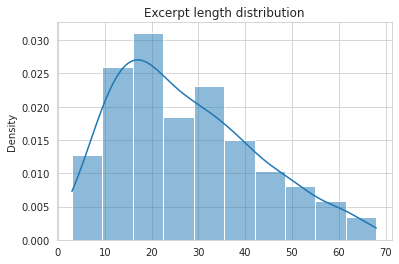

In [12]:
sns.histplot([len(sentence.split()) for sentence in stack_df['excerpt']], 
             kde=True, stat='density').set_title('Excerpt length distribution');

Conforme o gráfico pode-se observar que a maioria dos excertos possuem de 10 a 40 palavras.

##Limpeza de dados

In [13]:
# Verificando os sinais de pontuação que existem no dataset
def find_punctuation_chars(dataset: pd.DataFrame, column: str) -> None:
  punctuation_chars = set(string.punctuation) # Conjunto de caracteres de pontuação advindos da biblioteca string
  punctuation_found = set() # Conjunto vazio que receberá os caracteres de pontuação encontrados

  for excerpt in dataset[column]:
    for char in excerpt:
      if char in punctuation_chars:
        punctuation_found.add(char)

  if punctuation_found == set():
    print('Não foram econtrados caracteres de pontuação!')
  else:
    print("Os caracteres encontrados foram: ", punctuation_found)

In [14]:
find_punctuation_chars(stack_df, 'excerpt')

Os caracteres encontrados foram:  {'=', ')', '~', ':', '#', '!', '*', '"', '(', '+', ';', '/', '.', '$', ']', '[', '`', '-', '&', '?', "'", ',', '|'}


###Caracteres especiais:

*   \r = *Carriage return*
*   \n = Quebra de linha
*   Pronomes possessivos  \ 's (government's = government\'s)


In [15]:
stack_df['excerpt'] = stack_df['excerpt'].str.replace("\r", " ")
stack_df['excerpt'] = stack_df['excerpt'].str.replace("\'s", "")
stack_df['excerpt'] = stack_df['excerpt'].str.replace("\n", " ")

# Linha adicionada pois houve a junção incorreta de nomes no texto
stack_df['excerpt'] = stack_df['excerpt'].str.replace("-", " ")

###Sinais de pontuação
*   Sinais (? , ! . -)

In [16]:
punctuation = re.compile(r'[^A-Za-z0-9]+') # Qualquer caractere que não seja uma letra ou um dígito

In [17]:
# Substituir os caracteres de pontuação e dígitos por '', a partir do mapeamento da função punctuation
stack_df['excerpt'] = [content.translate(str.maketrans('','', string.punctuation)) for content in stack_df['excerpt']]
stack_df['excerpt'] = [content.translate(str.maketrans('','', string.digits)) for content in stack_df['excerpt']]

In [18]:
# Confirmar limpezas
find_punctuation_chars(stack_df, 'excerpt')

Não foram econtrados caracteres de pontuação!


###Stopwords

In [19]:
# Carregando as stopwords
stop_words = list(stopwords.words('english'))

In [20]:
for stop_word in stop_words:
  regex_stopword = r"\b" + stop_word + r"\b"
  stack_df['excerpt'] = stack_df['excerpt'].str.replace(regex_stopword, '')

<ipython-input-20-d88b1945f4f8>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  stack_df['excerpt'] = stack_df['excerpt'].str.replace(regex_stopword, '')


###Múltiplos espaços em branco

In [21]:
# Função para encontrar múltiplos espaços em branco consecutivos no dataframe
def check_multiple_whitespaces(dataset: pd.DataFrame, column: str):
  for text in dataset[column]:
    match = re.search(r'\s{2,}', text) # Procura por 2 ou mais espaços consecutivos
    
    if match:
      print(f"Múltiplos espaços em branco encontrados em: {text}")

In [22]:
check_multiple_whitespaces(stack_df, 'excerpt')

Múltiplos espaços em branco encontrados em: SPDY   experimental protocol  multiplexing multiple concurrent streams typically HTTP requestresponse streams   single TCP connection
Múltiplos espaços em branco encontrados em: ASPNET SignalR   library  ASPNET developers  makes  incredibly simple  add real time web functionality   applications What  real time web functionality It  ability    server side code push content   connected clients   happens  real time
Múltiplos espaços em branco encontrados em: Apache Kafka   publish subscribe messaging framework  Java designed  distributed high throughput systems
Múltiplos espaços em branco encontrados em: Kubernetes   open source implementation  container cluster management
Múltiplos espaços em branco encontrados em: Apache Camel   powerful open source integration framework based  known Enterprise Integration Patterns  powerful Bean Integration
Múltiplos espaços em branco encontrados em: Graphite   highly scalable real time graphing system specif

In [23]:
# Remove os espaços consecutivos
stack_df['excerpt'] = stack_df['excerpt'].apply(lambda x: re.sub(r'\s{2,}', ' ', x))

In [24]:
check_multiple_whitespaces(stack_df, 'excerpt')

##Padronizar os textos em letras minúsculas

In [25]:
stack_df['excerpt'] = stack_df['excerpt'].str.lower()

In [26]:
stack_df

,excerpt,classification
0,software defined networking sdn,1
1,spdy experimental protocol multiplexing multip...,1
2,aspnet signalr library aspnet developers makes...,0
3,apache kafka publish subscribe messaging frame...,2
4,kubernetes open source implementation containe...,1
...,...,...
262,docker provides high level api containerize un...,2
263,axon java application framework implementing s...,0
264,html hyper text markup language version umbrel...,0
265,c introduced features like dynamic objects com...,0


##Lematização

In [27]:
wnl = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

In [28]:
stack_df['excerpt'] = stack_df['excerpt'].apply(lambda x: " ".join([w.lemma_ for w in nlp(x) if w.lemma_ not in stop_words]))

In [29]:
stack_df

,excerpt,classification
0,software define networking sdn,1
1,spdy experimental protocol multiplexe multiple...,1
2,aspnet signalr library aspnet developer make i...,0
3,apache kafka publish subscribe message framewo...,2
4,kubernete open source implementation container...,1
...,...,...
262,docker provide high level api containerize uni...,2
263,axon java application framework implement soft...,0
264,html hyper text markup language version umbrel...,0
265,c introduce feature like dynamic object com in...,0


##Classificação do dataset

###Aplicação dos rótulos

In [30]:
stack_df.loc[3]['excerpt']

'apache kafka publish subscribe message framework java design distribute high throughput system'

In [31]:
stack_df.loc[3]['classification']

2

In [32]:
# Primeiro entender o assunto tratado em cada texto e classificá-los de acordo com os rótulos
stack_df.loc[16]['excerpt']

'swift application system programming language develop apple distribute open source use tag question specific swift language feature require code language'

In [33]:
stack_df.loc[16]['classification']

0

In [34]:
stack_df.loc[263]['excerpt']

'axon java application framework implement software use cqrs principle'

In [35]:
stack_df.loc[263]['classification']

0

In [36]:
stack_df.loc[157]['excerpt']

'java base datum integration framework use transformmapmanipulate datum various format csvfixlenxmlxbasecobollotus etc use standalone embeddedas library connect rdbmsjmssoapldapshttpftpziptar'

In [37]:
stack_df.loc[157]['classification']

2

In [38]:
stack_df.loc[200]['excerpt']

'hive data warehouse system hadoop facilitate easy datum summarization ad hoc query analysis large dataset store hadoop compatible file system hive provide mechanism project structure onto datum query datum use sql like language call hiveql'

###Divisão do conjunto em treino e teste

In [39]:
X_train, X_test, y_train, y_test = train_test_split(stack_df['excerpt'], 
                                                    stack_df['classification'], 
                                                    test_size=0.7, 
                                                    random_state=1)